In [1]:
!pip -q install transformers accelerate bitsandbytes trl mlflow boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.

In [2]:
import os
import torch
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,          # AutoModel for language modeling tasks
    AutoTokenizer,                # AutoTokenizer for tokenization
    BitsAndBytesConfig,           # Configuration for BitsAndBytes
    TrainingArguments,            # Training arguments for model training
    TrainerCallback
)
from peft import LoraConfig, PeftModel,PeftConfig
from trl import SFTTrainer

import pandas as pd
import numpy as np
import os
import logging as log
from datetime import datetime
import matplotlib.pyplot as plt

import mlflow
from mlflow.tracking import MlflowClient

import warnings
warnings.filterwarnings('ignore')

from data_prep import get_dataset, tokenize_and_mask
from peft_lora_config import Peft_Config

def setup_logging():
    # Remove all handlers associated with the root logger object.
    for handler in log.root.handlers[:]:
        log.root.removeHandler(handler)

    log.basicConfig(
        level=log.WARNING,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[log.StreamHandler()],
    )

logger = log.getLogger(__name__)
setup_logging()

# Dataset EDA

In [3]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("thangvip/vietnamese-legal-qa", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/21.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9715 [00:00<?, ? examples/s]

In [4]:
ds.shape

(9715, 5)

In [5]:
from tqdm.auto import tqdm
import pandas as pd

rows = []

for i in tqdm(range(len(ds))):
    qa_pairs = ds[i]["generated_qa_pairs"]
    for qa_pair in qa_pairs:
        rows.append({
            "question": qa_pair["question"],
            "answer": qa_pair["answer"]
        })

# Tạo DataFrame 1 lần
dataframe = pd.DataFrame(rows)

  0%|          | 0/9715 [00:00<?, ?it/s]

In [6]:
df = dataframe.assign(
    num_tokens=dataframe["answer"].apply(lambda text: len(str(text).split()))
)

# with pd.option_context('display.max_colwidth', None):
#     display(dataframe.sample(10))

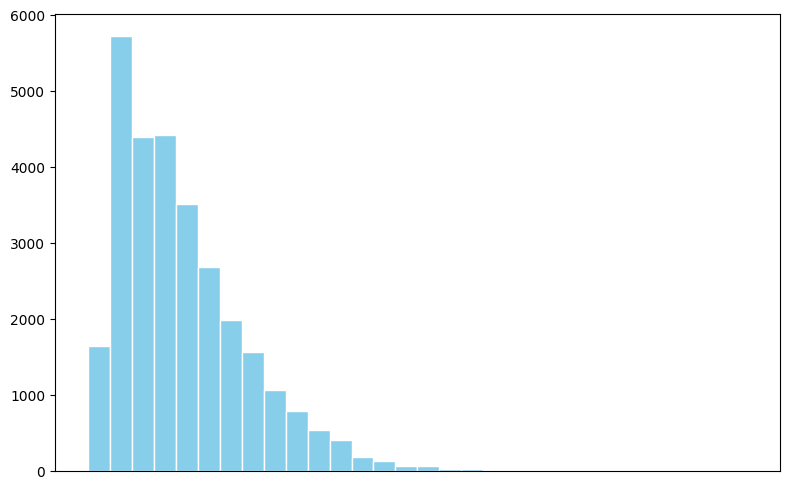

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(df["num_tokens"], bins=30, color="skyblue", edgecolor="white")
plt.xticks([])
plt.tight_layout()
plt.show()

In [8]:
print(f"size: {df.loc[df['num_tokens'] <= 256].size}")
df = df.loc[df["num_tokens"] < 256]
df.sample(10)

size: 72393


,question,answer,num_tokens
16149,"Theo Điều 13 của Luật Quản lý, sử dụng vốn Nhà...","Theo khoản 1 Điều 13 của Luật Quản lý, sử dụng...",69
27441,Viện trưởng Viện kiểm sát nhân dân tối cao có ...,Theo Khoản 1 Điều 63 của Luật Tổ chức Viện kiể...,74
18100,"Dựa trên Điều 19, vai trò của Nhà nước trong v...",Dựa trên Điều 19 của Luật Ngân hàng Nhà nước s...,111
27465,"Ai có thẩm quyền bổ nhiệm, miễn nhiệm, cách ch...",Theo Khoản 1 Điều 71 của Luật Tổ chức Viện kiể...,52
23930,Giả sử một hoạt động bảo hiểm vi mô tạo ra thặ...,Theo Điều 128 Dự thảo Luật Kinh doanh bảo hiểm...,163
8284,Khi nào người ra quyết định thanh tra có thể b...,"Theo khoản 1 Điều 97 của Luật Thanh tra, người...",84
19596,"Theo Điều 55 Luật Chứng khoán, cơ quan nào có ...",Theo Khoản 1 Điều 55 Luật Chứng khoán số 70/20...,52
3830,Giả sử một sự cố xảy ra khi việc ghép nối toa ...,"Trong tình huống được mô tả, cả Trưởng dồn và ...",180
17252,Giả sử một tổ chức không phải là tổ chức tín d...,Theo Khoản 7 Điều 161 của Luật Các tổ chức tín...,152
8989,Điều 81 của Luật Tố tụng hành chính phân loại ...,Điều 81 của Luật Tố tụng hành chính không trực...,247


# Set up PEFT and Lora Configs

In [9]:
config = Peft_Config()

In [10]:
# Step 2 :Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, config.bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=config.use_4bit,
    bnb_4bit_quant_type=config.bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=config.use_nested_quant,
)

In [11]:
# Step 3 :Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and config.use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [12]:
# Step 4 :Load base model
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map=config.device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [13]:
# Step 5 :Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.model_name, trust_remote_code=True)

special_tokens = {"additional_special_tokens": ["<|system|>", "<|user|>", "<|assistant|>"]}
tokenizer.add_special_tokens(special_tokens)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "right"

tokenizer.chat_template = """{% for message in messages %}
{% if message['role'] == 'system' %}
<|system|>
{{ message['content'].strip() }}
{{ eos_token }}
{% elif message['role'] == 'user' %}
<|user|>
{{ message['content'].strip() }}
{{ eos_token }}
{% elif message['role'] == 'assistant' %}
<|assistant|>
{{ message['content'].strip() }}
{{ eos_token }}
{% endif %}
{% endfor %}
{% if add_generation_prompt %}
<|assistant|>
{% endif %}"""

model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = tokenizer.pad_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [14]:
# Step 6 :Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=config.lora_alpha,
    lora_dropout=config.lora_dropout,
    r=config.lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

## s3 Config

In [15]:
import boto3
from dotenv import load_dotenv
import os

load_dotenv()

S3_BUCKET = "mlflow-artifacts-monitor"
s3_client = boto3.client(
    "s3",
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    region_name=os.environ["AWS_DEFAULT_REGION"]
)

## mlflow tracking

In [16]:
# mlflow set tracking
url = "https://victoria-communicable-sometimes.ngrok-free.dev"
mlflow.set_tracking_uri(url)
tracking_uri = mlflow.get_tracking_uri()
print(f"Current tracking uri: {tracking_uri}")

Current tracking uri: https://victoria-communicable-sometimes.ngrok-free.dev


In [17]:
mlflow.set_experiment("healthcarechatbot")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1761320025344, experiment_id='1', last_update_time=1761320025344, lifecycle_stage='active', name='healthcarechatbot', tags={}>

## training config

In [18]:
# Step 7 : Set training parameters
training_arguments = TrainingArguments(
    # --- Logging ---
    report_to="mlflow",
    run_name=f"{config.model_name_finetuned}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%s')}",

    # --- Paths & Core training ---
    output_dir=config.output_dir,
    num_train_epochs=config.num_train_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    optim=config.optim,
    save_steps=config.save_steps,
    logging_steps=config.logging_steps,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    fp16=config.fp16,
    bf16=config.bf16,
    max_grad_norm=config.max_grad_norm,
    max_steps=config.max_steps,
    warmup_ratio=config.warmup_ratio,
    group_by_length=config.group_by_length,
    lr_scheduler_type=config.lr_scheduler_type,

    # --- val ---
    # eval_steps=200,
    # save_strategy="steps",
    # eval_strategy="no",
    # save_total_limit=2,
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss"
)

In [19]:
ds_train = get_dataset()

message = ds_train['messages']

tokenized_chat = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt")
print(tokenizer.decode(tokenized_chat[0]))

  0%|          | 0/9715 [00:00<?, ?it/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

<|assistant|> 



In [20]:
ds_train

Dataset({
    features: ['messages'],
    num_rows: 8000
})

In [21]:
for example in ds_train.select(range(10)):
    print("---------------------------")
    print(f"question: {example["messages"][1]["content"]}")
    print(f"answer: {example["messages"][2]["content"]}")
    print("---------------------------")

---------------------------
question: Theo Điều 161 Dự thảo Luật Kinh doanh bảo hiểm (sửa đổi), cơ quan quản lý nhà nước về hoạt động kinh doanh bảo hiểm hoạt động trên những nguyên tắc nào?
answer: Theo Khoản 1 Điều 161 Dự thảo Luật Kinh doanh bảo hiểm (sửa đổi), cơ quan quản lý nhà nước về hoạt động kinh doanh bảo hiểm hoạt động trên nguyên tắc hợp pháp, cởi mở và công bằng.
---------------------------
---------------------------
question: Dựa vào Điều 59 của Luật Hàng không dân dụng Việt Nam, chức năng chính của Cảng vụ hàng không là gì?
answer: Theo Khoản 1 Điều 59 của Luật Hàng không dân dụng Việt Nam, chức năng chính của Cảng vụ hàng không là thực hiện chức năng quản lý nhà nước về hàng không dân dụng tại cảng hàng không và sân bay. Điều này có nghĩa là Cảng vụ hàng không chịu trách nhiệm quản lý, giám sát và điều tiết các hoạt động liên quan đến hàng không dân dụng trong phạm vi các cảng hàng không và sân bay cụ thể.
---------------------------
---------------------------
questi

In [22]:
from mlflow.models import infer_signature

sample = ds_train[0]["messages"]

# MLflow infers schema from the provided sample input/output/params
signature = infer_signature(
  model_input=sample[0]["content"],
  model_output=sample[1]["content"],
  # Parameters are saved with default values if specified
  params={"max_new_tokens": 256, "repetition_penalty": 1.15, "return_full_text": False},
)

signature

inputs: 
  [string (required)]
outputs: 
  [string (required)]
params: 
  ['max_new_tokens': long (default: 256), 'repetition_penalty': double (default: 1.15), 'return_full_text': boolean (default: False)]

In [23]:
# Apply mapping (non-batched for simplicity; batched mapping can be used for speed)
tokenized = ds_train.map(
    lambda example: tokenize_and_mask(example, tokenizer, config.max_seq_length), remove_columns=["messages"])
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_dataset = tokenized

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [24]:
train_dataset[0]

{'input_ids': tensor([    1, 32000, 29871,    13, 29933, 30540, 29876, 18916,   286, 30902,
         29873,   534, 31645,   301, 30052,  8092, 31142, 29873,  1374, 29976,
         29886, 10630, 30529, 29873, 13041,   266, 30069,   865,  1375, 29882,
         29892,  8092, 30069, 29876,   534, 30643,   301, 30997, 29875,   289,
           228,   189,   180,   865, 19538, 30717,   865, 10630, 30529, 29873,
           521, 29884,   228,   189,   172, 29876,   325, 30001,   270, 30701,
          7251, 31957, 29884, 29889,    13,     2, 29871,    13, 32001, 29871,
            13,  1576, 29877, 29871, 30250, 29875, 31343, 29884, 29871, 29896,
         29953, 29896,   360, 31874,   266, 30643, 29877,  3182, 31142, 29873,
         20311, 29882,   437, 27731,   289, 30643, 29877,  7251, 31957, 29885,
           313, 29879,   228,   190,   176, 29874, 29871, 30128,   228,   190,
           152, 29875,   511,   274, 30556, 29195,   439, 30643, 29876,   301,
         30052,   302, 29882, 30001,   

## Training

In [25]:
from transformers import TrainerCallback

class TrainLossEarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=2):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or "loss" not in logs:
            return
        current_loss = logs["loss"]
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping at step {state.global_step}")
                control.should_training_stop = True

class MLflowLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            for k, v in logs.items():
                if isinstance(v, (int, float)):
                    mlflow.log_metric(k, v, step=state.global_step)

In [26]:
mlflow_callback = MLflowLossCallback()
early_stopping_callback = TrainLossEarlyStoppingCallback(patience=2)

# Step 8 :Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,
    peft_config=peft_config,
    args=training_arguments,
    callbacks=[
        mlflow_callback,
        early_stopping_callback
    ]
)

Truncating train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [27]:
#  Step 9: Training steps
with mlflow.start_run() as run:
    trainer.train()

    # Save trained adapter model (checkpoint)
    checkpoint_dir = "checkpoint_model"
    trainer.model.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)

    # Merge and save final model with adapter
    model = trainer.model
    if hasattr(model, "merge_and_unload"):
        base_model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            dtype="float32",
            device_map=config.device_map
        )
        base_model.resize_token_embeddings(len(tokenizer))

        model = PeftModel.from_pretrained(base_model, checkpoint_dir)
        model = model.merge_and_unload()

        model.config.pad_token_id = tokenizer.pad_token_id
        model.config.eos_token_id = tokenizer.eos_token_id
        model.config.bos_token_id = tokenizer.bos_token_id

    merged_dir = "merged_model"
    model.save_pretrained(merged_dir)
    tokenizer.save_pretrained(merged_dir)

    # Upload merged model to S3
    s3_client = boto3.client("s3")
    bucket = "mlflow-artifacts-monitor"
    s3_prefix = f"models/health-llm/{run.info.run_id}"

    for root, _, files in os.walk(merged_dir):
        for f in files:
            path = os.path.join(root, f)
            key = f"{s3_prefix}/{os.path.relpath(path, merged_dir)}"
            s3_client.upload_file(path, bucket, key)

    model_uri = f"s3://{bucket}/{s3_prefix}"

    # Register the model metadata in MLflow
    REGISTERED_MODEL_NAME = "health-llm"

    result = mlflow.register_model(
        model_uri=model_uri,
        name=REGISTERED_MODEL_NAME
    )

    # Update metadata and tags
    client = MlflowClient()

    client.set_registered_model_tag(
        name=REGISTERED_MODEL_NAME, key="use_case", value="patient_service"
    )

    client.update_registered_model(
        name=REGISTERED_MODEL_NAME,
        description="A health-specific chatbot about daily Vietnamese sickness questions"
    )

    client.set_model_version_tag(
        name=REGISTERED_MODEL_NAME,
        version=result.version,
        key="validation_status",
        value="testing",
    )

    # Create alias for easier reference
    client.set_registered_model_alias(
        name=REGISTERED_MODEL_NAME,
        alias="champion",
        version=result.version,
    )

    print(f"Model registered successfully: version {result.version}")
    print(f"S3 path: {model_uri}")
    print(f"MLflow tracking: {run.info.run_id}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss
50,1.247900
100,1.011400
150,0.786300
200,0.673700
250,0.591500
300,0.561600
350,0.553100
400,0.531200
450,0.514100
500,0.520000


Early stopping at step 800


Successfully registered model 'health-llm'.
2025/10/25 10:26:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: health-llm, version 1
Created version '1' of model 'health-llm'.


Model registered successfully: version 1
S3 path: s3://mlflow-artifacts-monitor/models/health-llm/257cf75b54b449aeb1014c6b480d7bae
MLflow tracking: 257cf75b54b449aeb1014c6b480d7bae
🏃 View run rogue-stoat-832 at: https://victoria-communicable-sometimes.ngrok-free.dev/#/experiments/1/runs/257cf75b54b449aeb1014c6b480d7bae
🧪 View experiment at: https://victoria-communicable-sometimes.ngrok-free.dev/#/experiments/1
